In [1]:
import sys

import numpy as np
from river.decomposition import OnlineDMD, OnlineSVD
from river.preprocessing import Hankelizer
from river.utils import Rolling

Rolling.learn_one = Rolling.update
sys.path.append("../")

from functions.datasets import load_nprs43, load_nprs44  # noqa: E402
from functions.chdsubid import SubIDDriftDetector  # noqa: E402
from functions.plot import plot_chd  # noqa: E402

In [2]:
%load_ext autoreload
%autoreload 2

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


/var/folders/fz/53wksvdj0kzcjcxhq2_yfst80000gn/T/ipykernel_78085/221995357.py:77: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


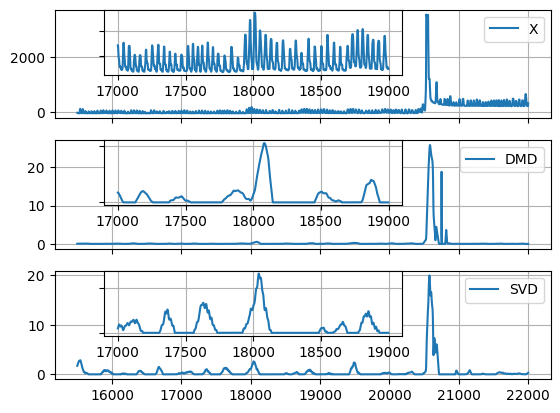

In [3]:
# Read data
X = load_nprs44()

# Initialize Hankelizer
hn = 80
hankelizer = Hankelizer(hn)

# Initialize Transformer
r = 2
init_size = 300
odmd = OnlineDMD(r=r, initialize=init_size, w=1.0)
# odmd = Rolling(
#     OnlineDMD(r=r, initialize=init_size, w=1.0, exponential_weighting=False),
#     init_size + 1,
# )
# Ref
osvd = OnlineSVD(r, initialize=init_size, force_orth=False)
# Initialize Drift Detector
ref_size = 100
test_size = 100
subid_dmd = SubIDDriftDetector(
    odmd,
    ref_size=ref_size,
    test_size=test_size,
    grace_period=init_size + test_size + 1,
)
# Ref
subid_svd = SubIDDriftDetector(
    osvd,
    ref_size=ref_size,
    test_size=test_size,
    grace_period=init_size + test_size + 1,
)

# Build pipeline
pipeline_dmd = hankelizer | subid_dmd
pipeline_svd = Hankelizer(hn) | subid_svd

# Prepare arrays for storing results
scores_dmd = np.zeros(X.shape[0], dtype=float)
scores_svd = np.zeros(X.shape[0], dtype=float)
dist = np.zeros((X.shape[0], 2), dtype=float)
modes = np.empty((X.shape[0], hn, r), dtype=float)
mean_modes = np.empty(X.shape[0], dtype=float)
svs = np.zeros((X.shape[0], r, r), dtype=float)
us = np.zeros((X.shape[0], hn, r), dtype=float)
As = np.zeros((X.shape[0], r, r), dtype=float)

# Run pipeline
for i, (x) in enumerate(X):
    # print every 1000
    if i % 1000 == 0:
        print(i)

    pipeline_dmd.learn_one({"x": x})
    pipeline_svd.learn_one({"x": x})

    scores_dmd[i] = subid_dmd.score
    scores_svd[i] = subid_svd.score
    if hasattr(subid_dmd.subid, "modes"):
        modes[i, :, :] = odmd.modes
        mean_modes[i] = modes[i, :, :].mean()
        svs[i, :, :] = odmd._svd._S
        us[i, :, :] = odmd._svd._U
        As[i, :, :] = odmd.A
        dist[i, :] = subid_dmd.distances

# Plot results
fig, axs = plot_chd(
    [X, scores_dmd, scores_svd],
    labels=["X", "DMD", "SVD"],
    idx_start=15500,
    idx_end=22000,
    idx_in_start=17000,  # Original 16190
    idx_in_end=19000,  # Original 16344
)
fig.show()

fig_name = (
    f"results/nprs/nprs44-chd_r{r}-"
    f"{f'roll_{odmd.window_size}' if isinstance(odmd, Rolling) else 'noroll'}-"
    f"dmd_w{odmd.w}-h{hn}.png"
)
fig.savefig(fig_name)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000


/var/folders/fz/53wksvdj0kzcjcxhq2_yfst80000gn/T/ipykernel_78085/1449417893.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


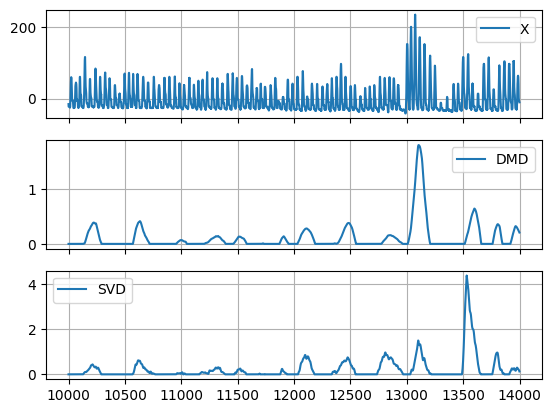

In [17]:
# Read data
X = load_nprs43()

# Initialize Hankelizer
hn = 80
hankelizer = Hankelizer(hn)

# Initialize Transformer
r = 2
init_size = 300
odmd = OnlineDMD(r=r, initialize=init_size, w=1.0)
# odmd = Rolling(
#     OnlineDMD(r=r, initialize=init_size, w=1.0, exponential_weighting=False),
#     300,
# )
# Ref
osvd = OnlineSVD(r, initialize=init_size, force_orth=False)
# Initialize Drift Detector
ref_size = 100
test_size = 100
subid_dmd = SubIDDriftDetector(
    odmd,
    ref_size=ref_size,
    test_size=test_size,
    grace_period=init_size + test_size + 1,
)
# Ref
subid_svd = SubIDDriftDetector(
    osvd,
    ref_size=ref_size,
    test_size=test_size,
    grace_period=init_size + test_size + 1,
)

# Build pipeline
pipeline_dmd = hankelizer | subid_dmd
pipeline_svd = Hankelizer(hn) | subid_svd

# Prepare arrays for storing results
scores_dmd = np.zeros(X.shape[0], dtype=float)
scores_svd = np.zeros(X.shape[0], dtype=float)
modes = np.empty((X.shape[0], hn, 2), dtype=float)
mean_modes = np.empty(X.shape[0], dtype=float)
svs = np.zeros((X.shape[0], 2, 2), dtype=float)
us = np.zeros((X.shape[0], hn, 2), dtype=float)
As = np.zeros((X.shape[0], 2, 2), dtype=float)

# Run pipeline
for i, (x) in enumerate(X):
    # print every 1000
    if i % 1000 == 0:
        print(i)

    pipeline_dmd.learn_one({"x": x})
    pipeline_svd.learn_one({"x": x})

    scores_dmd[i] = subid_dmd.score
    scores_svd[i] = subid_svd.score
    if hasattr(subid_dmd.subid, "modes"):
        modes[i, :, :] = subid_dmd.subid.modes
        mean_modes[i] = modes[i, :, :].mean()
        svs[i, :, :] = subid_dmd.subid._svd._S
        us[i, :, :] = subid_dmd.subid._svd._U
        As[i, :, :] = subid_dmd.subid.A

# Plot results
fig, axs = plot_chd(
    [X, scores_dmd, scores_svd],
    labels=["X", "DMD", "SVD"],
    idx_start=10000,
    idx_end=14000,
)
fig.show()

fig_name = (
    f"results/nprs/nprs43-chd_r{r}-"
    f"{f'roll_{odmd.window_size}' if isinstance(odmd, Rolling) else 'noroll'}-"
    f"dmd_w{odmd.w}-h{hn}.png"
)
fig.savefig(fig_name)